# SETTINGS

## Importamos Librerías

In [1]:
import pandas as pd
import numpy as np
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
import json
import os
print(os.getcwd())
# spacy.__version__
# Check GPU information
# !nvidia-smi

C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner


## Creamos una carpeta para entrenar el modelo

In [2]:
def generate_model_folder(base_folder='ner_model_', start_index=1):
    index = start_index
    while True:
        folder_name = f"{base_folder}{index}"
        if not os.path.exists(folder_name):
            os.makedirs(folder_name)
            ner_model_path = os.path.abspath(folder_name)

            yield folder_name,ner_model_path
        index += 1

# Invocamos al generador
folder_generator = generate_model_folder()

# Get the next available folder
ner_model_folder, ner_model_path = next(folder_generator)

print(f"Created folder: {ner_model_folder}")
print(f'new path is : {ner_model_path}')

Created folder: ner_model_4
new path is : C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_4


## levantamos los datos y los guardamos con formato spacy en la carpeta del modelo

In [3]:
data = pd.read_pickle(r'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\dataset_500_casos\\estatutos_anotados.pkl')
data = data.values.tolist()
data[0]

['Esc 96 del 30/5/17, Fº321, Reg 176 CABA. Socios: Emilio Adrián LEIVA, soltero, DNI 26007027, 11/5/77, Azamor 2325, Lomas de Zamora, Pcia de Bs As; Daniel Horacio SÁNCHEZ, casado, DNI 25747237, 11/1/77, Azamor 2163, Lomas de Zamora, Pcia de Bs As; y Majed MOHANNA, soltero, DNI 18886526, 18/2/74, Tucumán 2401, CABA; todos argentinos y empresarios, constituyen domicilio Especial en Sede Social: Tucumán 2454, CABA. 1) ADM TEX GROUP SA 2) 99 años 3) Objeto: Compra, venta, importación, exportación, fabricación, representación, consignación y distribución de telas, prendas de vestir, indumentaria y accesorios, fibras, tejidos, hilados y calzados y las materias primas que lo componen. 4) $\xa0500.000. 5) Uno a cinco, 3 años. 6) Sin sindicatura. 7) Cierre Ejercicio: 31/12. Presidente: Emilio Adrian LEIVA; Director Suplente: Daniel Horacio SÁNCHEZ. Ambos aceptan sus cargos y constituyen domicilio Especial en Sede Social. Autorizado según instrumento público Esc. Nº\xa096 de fecha 30/05/2017 Re

In [4]:
# Define a function to create spaCy DocBin objects from the annotated data
def get_spacy_doc(file, data):
  # Create a blank spaCy pipeline
  nlp = spacy.blank('es')
  db = DocBin()

  # Iterate through the data
  for text, annot in tqdm(data):
    doc = nlp.make_doc(text)
    annot = annot['entities']

    ents = []
    entity_indices = []

    # Extract entities from the annotations
    for start, end, label in annot:
      skip_entity = False
      for idx in range(start, end):
        if idx in entity_indices:
          skip_entity = True
          break
      if skip_entity:
        continue

      entity_indices = entity_indices + list(range(start, end))
      try:
        span = doc.char_span(start, end, label=label, alignment_mode='strict')
      except:
        continue

      if span is None:
        # Log errors for annotations that couldn't be processed
        err_data = str([start, end]) + "    " + str(text) + "\n"
        file.write(err_data)
      else:
        ents.append(span)

    try:
      doc.ents = ents
      db.add(doc)
    except:
      pass

  return db

In [5]:
# Split the annotated data into training and testing sets
from sklearn.model_selection import train_test_split
training, dev = train_test_split(data, test_size=0.1, random_state=42)
train, test = train_test_split(training, test_size=0.2, random_state=42)

# Display the number of items in the training and testing sets
len(train), len(test), len(dev)

(290, 73, 41)

In [6]:
file = open(os.path.join(ner_model_path,'train_file.txt'),'w')

# Create spaCy DocBin objects for training and testing data
db = get_spacy_doc(file, train)
db.to_disk(os.path.join(ner_model_path,'train.spacy'))


db = get_spacy_doc(file, test)
db.to_disk(os.path.join(ner_model_path,'test.spacy'))

db = get_spacy_doc(file, dev)
db.to_disk(os.path.join(ner_model_path,'dev.spacy'))

file.close()

100%|█████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 152.42it/s]


In [7]:
os.listdir(ner_model_path)

['dev.spacy', 'test.spacy', 'train.spacy', 'train_file.txt']

## generamos el archivo config.cfg

Generamos el archivo base_config y lo dejamos en la carpeta nueva que creamos.

https://spacy.io/usage/training#quickstart


https://spacy.io/usage/training#config

In [8]:
def generate_spacy_init_command(base_path, config_filename = "config.cfg"):
    """
    Generate a string for running the 'spacy init fill-config' command.

    Args:
    - base_path (str): The base path where the files are located.
    - config_filename (str): The name of the configuration file.

    Returns:
    - str: The generated command string.
    """
    if base_path is None:
        
        base_path = os.getcwd()
        
    command = f"!python -m spacy init fill-config {base_path}/base_config.cfg {base_path}/config/{config_filename}"
    return command

# Example usage:
base_path = "/your_file_path"
config_filename = "config.cfg"

spacy_init_command = generate_spacy_init_command(ner_model_path, config_filename)
print(spacy_init_command)

!python -m spacy init fill-config C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3/base_config.cfg C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3/config/config.cfg


In [9]:
!python -m spacy init fill-config C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3/base_config.cfg C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3/config/config.cfg

[+] Auto-filled config with all values
[+] Saved config
C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3\config\config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


# TRAINING

Vamos a la ruta

In [10]:
# vamos a la carpeta donde vamos a entrenar:
os.chdir(ner_model_path)
os.getcwd()

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\ner_model_3'

¡y entrenamos!

Recorda que spacy tiene su lenguaje: 

spacy ---- mundo

train ---- train

dev   ---- test

eval  ---- dev

In [11]:
# Train a spaCy NER model using the provided configuration and data
!python -m spacy train ./config/config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./test.spacy --paths.eval ./dev.spacy --verbose

[i] Saving to output directory: .
[i] Using CPU

=========================== Initializing pipeline ===========================
[+] Initialized pipeline

============================= Training pipeline =============================
[i] Pipeline: ['tok2vec', 'ner']
[i] Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    175.64    0.00    0.00    0.00    0.00
  0     200       3679.91   6336.53   73.86   76.28   71.59    0.74
  1     400        281.04   1244.20   83.11   82.84   83.39    0.83
  2     600         50.74    702.53   89.08   90.14   88.04    0.89
  2     800        411.88    994.36   82.57   84.14   81.06    0.83
  3    1000         97.47    514.59   88.85   85.32   92.69    0.89
  4    1200         82.01    462.86   91.25   90.66   91.86    0.91
  4    1400       1116.67    455.64   90.86   89.26   92.52    0.91
  5    1600        157.91 

[2024-02-22 15:54:31,400] [DEBUG] Config overrides from CLI: ['paths.train', 'paths.dev', 'paths.eval']
[2024-02-22 15:54:34,789] [INFO] Set up nlp object from config
[2024-02-22 15:54:34,805] [DEBUG] Loading corpus from path: test.spacy
[2024-02-22 15:54:34,807] [DEBUG] Loading corpus from path: train.spacy
[2024-02-22 15:54:34,807] [INFO] Pipeline: ['tok2vec', 'ner']
[2024-02-22 15:54:34,810] [INFO] Created vocabulary
[2024-02-22 15:54:37,984] [INFO] Added vectors: es_core_news_lg
[2024-02-22 15:54:37,985] [INFO] Finished initializing nlp object
[2024-02-22 15:54:43,196] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
[2024-02-22 15:54:43,214] [DEBUG] Loading corpus from path: test.spacy
[2024-02-22 15:54:43,216] [DEBUG] Loading corpus from path: train.spacy


# PERFORMANCE

In [9]:
ner_model_path= r'C:\Users\juani\Documents\3_My_Jupiter_Notebooks\0_github\ner\ner_model_3'

In [6]:
import matplotlib.pyplot as plt
import warnings

In [10]:
os.path.join(ner_model_path,'model-best')

'C:\\Users\\juani\\Documents\\3_My_Jupiter_Notebooks\\0_github\\ner\\ner_model_3\\model-best'

In [6]:
# !python -m spacy download es_dep_news_trf

In [11]:
nlp = spacy.load(os.path.join(ner_model_path,'model-best'))

In [12]:
warnings.simplefilter(action='ignore', category=FutureWarning)

# leavntamos los datos de performance:
d = nlp.__dict__['_meta']['performance']

# armamos un dataframe por variable:
ents_per_type = pd.DataFrame(d['ents_per_type'])

# armamos una columna para el modelo general:

ents_per_type['MODELO'] = np.nan
ents_per_type['MODELO'][ents_per_type.index=='p'] = d['ents_p']
ents_per_type['MODELO'][ents_per_type.index=='r'] = d['ents_r']
ents_per_type['MODELO'][ents_per_type.index=='f'] = d['ents_f']
ents_per_type.round(2)

,SOCIO,DNI,OBJETO,SEDE,ESCRIBANO,MODELO
p,0.96,0.94,0.77,0.88,0.97,0.92
r,0.96,0.96,0.82,0.84,0.96,0.93
f,0.96,0.95,0.80,0.86,0.97,0.92


<Axes: >

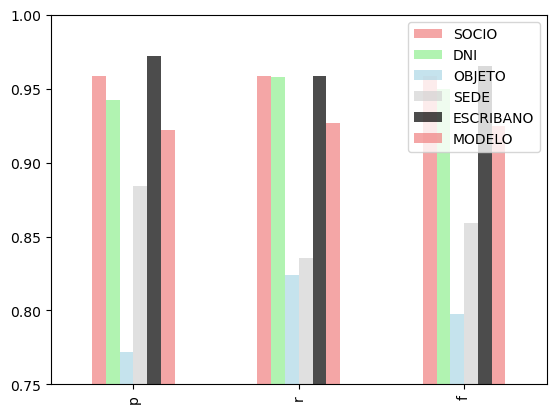

In [13]:
ents_per_type.plot.bar(ylim=(0.75,1),color=['lightcoral', 'lightgreen', 'lightblue','lightgray','black'], alpha=0.7)

# EXAMPLE

In [14]:
text = '''
KEYBOARD S.A.Escritura Nº 362 de fecha 27/06/2023. Orlando DI FONZO, argentino, empresario, casado en primeras nupcias con 
Amalia Rinaldi, DNI 8.609.671, CUIT Nº 20-08609671-5; y Gonzalo Gastón DI FONZO, argentino, empresario, soltero, 
DNI 33.689.504, CUIT 23-33689504-9, ambos domiciliados en Carmen Puch Nº 1000, de la Localidad y Partido de 
Pilar, Provincia de Buenos Aires: Resuelven que la sociedad se adecúe voluntariamente a las disposiciones del art. 
124 de la ley 19.550 y aprueban todas las estipulaciones del estatuto: 1) Keyboard S.A. 2) Duración: 30 años desde 
inscripción. 3) Objeto: Compra, venta, hipoteca, arrendamiento y toda clase de operaciones con bienes inmuebles. 
Realizar y/o administrar inversiones. Importaciones, exportaciones, comisiones, representaciones y mandatos. 
Operaciones financieras relacionadas con sus actividades principales. 4) Capital: $  1.000.000.-, representado 
por diez mil acciones ordinarias, nominativas no endosables, de v/n $ 100.- cada una y derecho a un voto por 
acción. 5) Dirección y administración: a cargo del directorio compuesto del número de miembros que determine 
la asamblea, entre un mínimo de uno y un máximo de cinco, por tres ejercicios. 6) Prescindencia de Sindicatura. 
7) Suscripción: Orlando DI FONZO y Gonzalo Gastón DI FONZO suscriben la cantidad de cinco mil acciones 
cada uno, lo que representa el 50% del capital social. Directorio: PRESIDENTE: Orlando DI FONZO; y DIRECTOR 
SUPLENTE: Gonzalo Gastón DI FONZO, quienes constituyen domicilio especial en la sede social, fijada en la calle 
Lavalle Nº 643, Piso 5º, Oficina “D”, C.A.B.A. Cierre ejercicio social: 30 de junio de cada año. Autorizado según 
instrumento público Esc. Nº 362 de fecha 27/06/2023 Reg. Nº 1017.Lucía Agundez - T°: 114 F°: 540 C.P.A.C.F.
'''

In [15]:
# Process the extracted text using the loaded spaCy NER model
doc = nlp(text)
# Iterate through the named entities (entities) recognized by the model
for ent in doc.ents:
  # Print the recognized text and its corresponding label
  print(ent.text, "  ->>>>  ", ent.label_)

Gonzalo Gastón DI FONZO   ->>>>   SOCIO
33.689.504   ->>>>   DNI
Objeto: Compra, venta, hipoteca, arrendamiento y toda clase de operaciones con bienes inmuebles. 
Realizar y/o administrar inversiones. Importaciones, exportaciones, comisiones, representaciones y mandatos. 
Operaciones financieras relacionadas con sus actividades principales.   ->>>>   OBJETO
